In [41]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [71]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
endingstate= tensor(basis(3,0),basis(3,2))
startingstate.dims=[[9],[1]]
endingstate.dims=[[9],[1]]
print (startingstate)
print (endingstate)

U=endingstate * startingstate.dag()
U.dims=[[9],[9]]
U

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [72]:

R = 150 #GRAPE itterations

T = 1
times = np.linspace(0, T, 100)


#wirting our terms so I can actually read the hamiltonian
#Nuc terms are second qubit
#Elec qubit is first qubit

nuclear_spin = 1
electron_spin = 1
sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix



#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)

H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)
print (H_opsENz)

#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx, H_opsEy, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$',
            r'$uE_{z}$',
            r'$uN_{x}$',
            r'$uN_{y}$',
            r'$uN_{z}$',
            r'$uEN_{x}$',
            r'$uEN_{y}$',
            r'$uEN_{z}$']


Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


# Defining hamiltonian and constants 

In [59]:
#defining hamiltonian for NV center

#constants

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14e6
f_transverse_magnetic_hyperfine = -2.7e6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297e7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    
bvector=[0,0,1]


#witing out hamiltonian terms

H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))

H5 = ((uB/h) * g_factor_electron) * tensor((sigmaxE*bvector[0] + sigmayE*bvector[1] + sigmazE*bvector[2]), identity3)

H6 = gyromagnetic_constant_nuclear * tensor(identity3,(sigmaxN*bvector[0] + sigmayN*bvector[1] + sigmazN*bvector[2]))
          
    
H0= H1+H2 +H3 +H4+H5 +H6
H0.dims=[[9],[9]] #changing dimensions bc dot products are silly
H0 #hamiltonian without b field term



Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.89876124e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.89916860e+10  0.00000000e+00 -2.70000000e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.89857396e+10  0.00000000e+00
  -2.70000000e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -2.70000000e+06  0.00000000e+00 -1.91192692e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.70000000e+06  0.00000000e+00
  -1.90999333e+09  0.00000000e+00 -2.70000000e+06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.91807975e+09  0.00000000e+00 -2.70000000e+06
   0.00000000e+00]
 [ 0

# Plot pulses

In [60]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [61]:
#doing GRAPE!

result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time:  10.33s. Est. time left: 00:00:01:32
20.0%. Run time:  20.11s. Est. time left: 00:00:01:20
30.0%. Run time:  30.39s. Est. time left: 00:00:01:10
40.0%. Run time:  40.67s. Est. time left: 00:00:01:01
50.0%. Run time:  50.78s. Est. time left: 00:00:00:50
60.0%. Run time:  61.15s. Est. time left: 00:00:00:40
70.0%. Run time:  71.74s. Est. time left: 00:00:00:30
80.0%. Run time:  82.10s. Est. time left: 00:00:00:20
90.0%. Run time:  91.99s. Est. time left: 00:00:00:10
Total run time: 101.53s


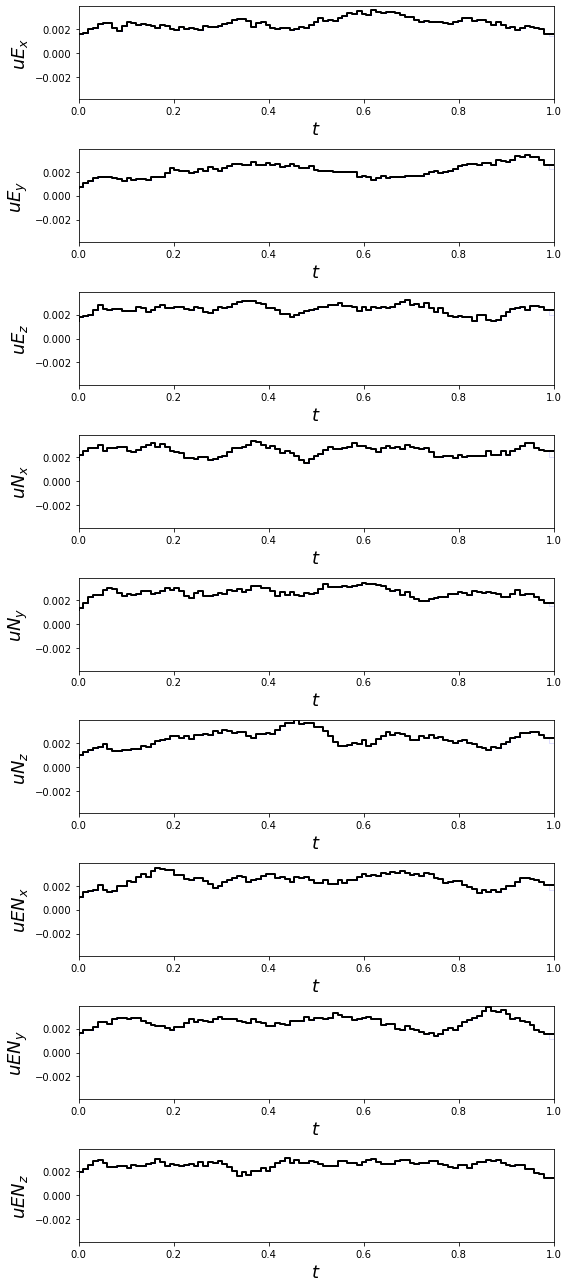

In [62]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [66]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [67]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[-0.8947907 +0.44648598j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.91731804+0.39815506j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.11305318-0.99358864j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.93421438+0.35670918j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.  

In [68]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[-0.8947907+0.44648598j]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]
 [ 0.       +0.j        ]]


In [69]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1.00000012 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.     

0.0

# Plotting City Scape


In [38]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='State Tomography for Real State')

[[0.99999992+0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.  

VisualizationError: 'Input is not a multi-qubit quantum state.'

In [39]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='State Tomography for Ideal State')

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


VisualizationError: 'Input is not a multi-qubit quantum state.'